In [ ]:
import os
import glob
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from ruamel.yaml import YAML
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [2]:
def _parse_function(file):
    features = {
        'label': tf.FixedLenFeature([], tf.int64),
        'audio_inputs': tf.FixedLenFeature([], tf.string),
        'scene': tf.FixedLenFeature([], tf.string),
        'source_file': tf.FixedLenFeature([], tf.string)
    }
    parsed_features = tf.parse_single_example(file, features=features)
    label = tf.cast(parsed_features['label'], tf.int64)
    source_file = tf.decode_raw(parsed_features['source_file'], tf.uint8)
    return label, source_file

def get_input_fn(filenames, batch_size):
    def _input_fn():
        dataset = tf.data.TFRecordDataset(filenames)
        dataset = dataset.map(_parse_function)
        dataset = dataset.batch(batch_size)
        iterator = dataset.make_one_shot_iterator()
        # There are a couple of elements here. 
        next_element = iterator.get_next()
        return next_element
    return _input_fn

def data_meta_parse(yaml_file):
    with open(yaml_file) as f:
        yaml = YAML(typ='safe')
        yaml_map = yaml.load(f)
        set_dict = dict()
        for file_dict in yaml_map:
            set_dict[file_dict['mixture_audio_filename']] = dict_to_object(file_dict)
        return set_dict
    
class dict_to_object(object):
    def __init__(self, dictionary):
        for k, v in dictionary.items():
            setattr(self, k, v)

    def __str__(self):
        return "\n".join(["{} : {}".format(k,v) for k,v in self.__dict__.items()])

In [3]:
def sep_eval_on_ebr(scene_name, model):
    data_dir = '/Volumes/exSSD/RED_ARCHIVE/data'
    evaltest_dir = os.path.join(data_dir,"TUT-rare-sound-events-2017-evaluation/data",
        "mixture_data/evaltest/bbb81504db15a03680a0044474633b67")
    test_meta_dir = os.path.join(evaltest_dir,"meta")
    test_meta_dir_file = os.path.join(test_meta_dir,"mixture_recipes_evaltest_")
    b_test_meta = data_meta_parse(test_meta_dir_file+"babycry.yaml")
    gs_test_meta = data_meta_parse(test_meta_dir_file+"gunshot.yaml")
    gb_test_meta = data_meta_parse(test_meta_dir_file+"glassbreak.yaml")  
    filenames = ['data_binaries/test/babycry/{}/babycry_{}_pos.tfrecord'.format(scene_name,scene_name), 
                 'data_binaries/test/babycry/{}/babycry_{}_neg.tfrecord'.format(scene_name,scene_name), 
                 'data_binaries/test/glassbreak/{}/glassbreak_{}_pos.tfrecord'.format(scene_name,scene_name), 
                 'data_binaries/test/glassbreak/{}/glassbreak_{}_neg.tfrecord'.format(scene_name,scene_name), 
                 'data_binaries/test/gunshot/{}/gunshot_{}_pos.tfrecord'.format(scene_name,scene_name), 
                 'data_binaries/test/gunshot/{}/gunshot_{}_neg.tfrecord'.format(scene_name,scene_name)]
    input_fn_test = get_input_fn(filenames, 1)
    labels_op, meta_op = input_fn_test()
    test_meta = {**b_test_meta, **gs_test_meta, **gb_test_meta}

    preds = np.load('/volumes/exSSD/RED_ARCHIVE/preds/test_preds_{}/preds_test_{}_train_{}.npy'.format(model, model, scene_name))
    targets = np.load('/volumes/exSSD/RED_ARCHIVE/targets/targets_{}/targets_test_{}_train_{}.npy'.format(model, model, scene_name))
    preds = np.squeeze(preds)
    targets = np.squeeze(targets)

    mse = ((preds-targets)**2).mean(axis=1)

    label_list = []
    ebr_list = []

    neg = [['mse', 'label', 'ebr']]
    mid = []
    high = []
    low = []
    i = 0
    with tf.Session() as sess:
        while True:
            try:
                label, meta = sess.run([labels_op, meta_op])
                # Deserialise (was stored as an int)
                meta_str = ''.join(chr(i) for i in meta[0])
                try:
                    # Get name of file and check the event-to-backround-ratio of this meta file. 
                    ebr = test_meta['_'.join(meta_str.split('_')[:-1])+'.wav'].ebr
                except KeyError:
                    print('File meta not found')
                    break
                if label == 1:
                    # db are floats. 
                    if math.isclose(ebr,0):
                        mid.append([mse[i], label[0], ebr])
                    elif ebr < 0:
                        low.append([mse[i], label[0], ebr])
                    elif ebr > 0:
                        high.append([mse[i], label[0], ebr])
                else:
                    neg.append([mse[i], label[0], ebr])
                i+=1
                label_list.append(label[0])
            except tf.errors.OutOfRangeError:
                break
    low_full = neg + low
    mid_full = neg + mid
    high_full = neg + high
    
    df_low = pd.DataFrame(low_full[1:], columns=low_full[0])
    df_mid = pd.DataFrame(mid_full[1:], columns=mid_full[0])
    df_high = pd.DataFrame(high_full[1:], columns=high_full[0])
    
    low_fpr, low_tpr, _ = roc_curve(df_low['label'].values, df_low['mse'].values)
    auc_low = auc(low_fpr, low_tpr)
    
    mid_fpr, mid_tpr, _ = roc_curve(df_mid['label'].values, df_mid['mse'].values)
    auc_mid = auc(mid_fpr, mid_tpr)

    high_fpr, high_tpr, _ = roc_curve(df_high['label'].values, df_high['mse'].values)
    auc_high = auc(high_fpr, high_tpr)

    fpr, tpr, _ = roc_curve(label_list, mse)
    auc_com = auc(fpr,tpr)
    return auc_low, auc_mid, auc_high, auc_com

In [ ]:
scenes = (
    "beach",
    "bus",
    "cafe_restaurant",
    "car",
    "city_center",
    "forest_path",
    "grocery_store",
    "home",
    "library",
    "metro_station",
    "office",
    "park",
    "residential_area",
    "train",
    "tram"
)

auc_neg_6dB = []
auc_0dB = []
auc_pos_6dB = []
auc_com = []

for scene_name in scenes:
    auc_low, auc_mid, auc_high, auc_all = sep_eval_on_ebr(scene_name, 'WaveNet')
    auc_neg_6dB.append(auc_low)
    auc_0dB.append(auc_mid)
    auc_pos_6dB.append(auc_high)
    auc_com.append(auc_all)
    print('Processed scene {} for WaveNet.'.format(scene_name))

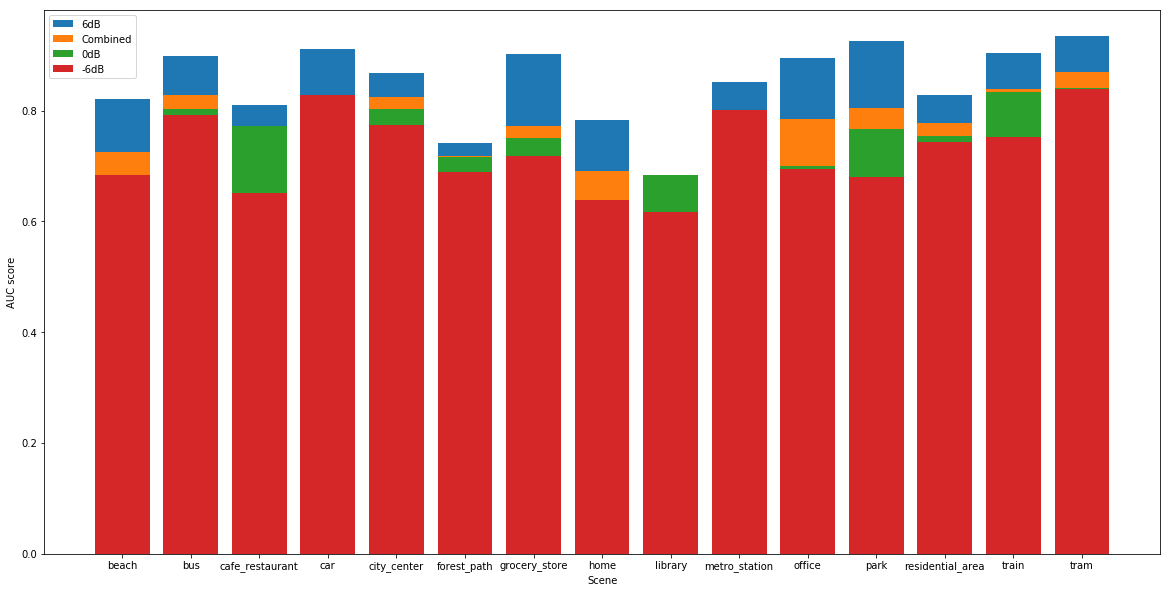

In [27]:
num_scenes = np.arange(len(scenes))
plt.figure(figsize=(20,10))
high_bar = plt.bar(num_scenes, auc_pos_6dB)
com_bar = plt.bar(num_scenes,auc_com)
mid_bar = plt.bar(num_scenes,auc_0dB)
low_bar = plt.bar(num_scenes,  auc_neg_6dB)
plt.legend((high_bar[0], com_bar[0], mid_bar[0],low_bar[0] ), ('6dB', 'Combined', '0dB', '-6dB'))
plt.xticks(num_scenes, scenes)
plt.xlabel('Scene')
plt.ylabel('AUC score')
plt.show()

In [28]:
scenes = (
    "beach",
    "bus",
    "cafe_restaurant",
    "car",
    "city_center",
    "forest_path",
    "grocery_store",
    "home",
    "library",
    "metro_station",
    "office",
    "park",
    "residential_area",
    "train",
    "tram"
)

auc_neg_6dB = []
auc_0dB = []
auc_pos_6dB = []
auc_com = []

for scene_name in scenes:
    auc_low, auc_mid, auc_high, auc_all = sep_eval_on_ebr(scene_name, 'CAE')
    auc_neg_6dB.append(auc_low)
    auc_0dB.append(auc_mid)
    auc_pos_6dB.append(auc_high)
    auc_com.append(auc_all)
    print('Processed scene {} for CAE.'.format(scene_name))

Processed scene beach for CAE.
Processed scene bus for CAE.
Processed scene cafe_restaurant for CAE.
Processed scene car for CAE.
Processed scene city_center for CAE.
Processed scene forest_path for CAE.
Processed scene grocery_store for CAE.
Processed scene home for CAE.
Processed scene library for CAE.
Processed scene metro_station for CAE.
Processed scene office for CAE.
Processed scene park for CAE.
Processed scene residential_area for CAE.
Processed scene train for CAE.
Processed scene tram for CAE.


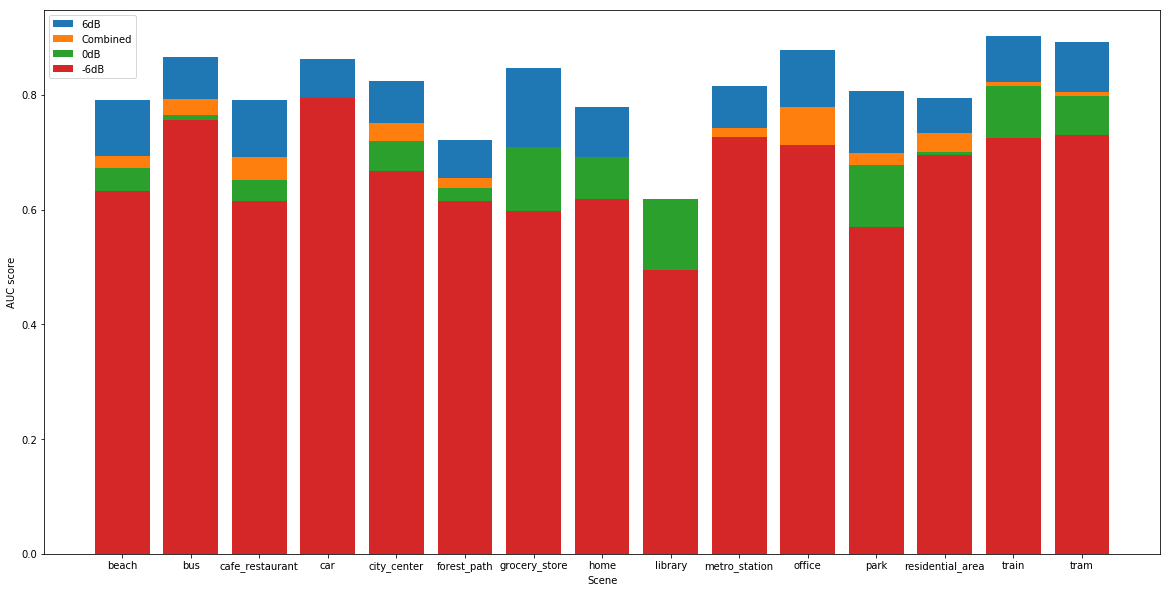

In [29]:
num_scenes = np.arange(len(scenes))
plt.figure(figsize=(20,10))
high_bar = plt.bar(num_scenes, auc_pos_6dB)
com_bar = plt.bar(num_scenes,auc_com)
mid_bar = plt.bar(num_scenes,auc_0dB)
low_bar = plt.bar(num_scenes,  auc_neg_6dB)
plt.legend((high_bar[0], com_bar[0], mid_bar[0],low_bar[0] ), ('6dB', 'Combined', '0dB', '-6dB'))
plt.xticks(num_scenes, scenes)
plt.xlabel('Scene')
plt.ylabel('AUC score')
plt.show()

In [ ]:
model = 'WaveNet'
data_dir = '/Volumes/exSSD/RED_ARCHIVE/data'
evaltest_dir = os.path.join(data_dir,"TUT-rare-sound-events-2017-evaluation/data",
    "mixture_data/evaltest/bbb81504db15a03680a0044474633b67")
test_meta_dir = os.path.join(evaltest_dir,"meta")
test_meta_dir_file = os.path.join(test_meta_dir,"mixture_recipes_evaltest_")
b_test_meta = data_meta_parse(test_meta_dir_file+"babycry.yaml")
gs_test_meta = data_meta_parse(test_meta_dir_file+"gunshot.yaml")
gb_test_meta = data_meta_parse(test_meta_dir_file+"glassbreak.yaml")  
filenames = ['/volumes/exSSD/RED_ARCHIVE/data_binaries/test/babycry/{}/babycry_{}_pos.tfrecord'.format(scene_name,scene_name), 
             '/volumes/exSSD/RED_ARCHIVE/data_binaries/test/babycry/{}/babycry_{}_neg.tfrecord'.format(scene_name,scene_name), 
             '/volumes/exSSD/RED_ARCHIVE/data_binaries/test/glassbreak/{}/glassbreak_{}_pos.tfrecord'.format(scene_name,scene_name), 
             '/volumes/exSSD/RED_ARCHIVE/data_binaries/test/glassbreak/{}/glassbreak_{}_neg.tfrecord'.format(scene_name,scene_name), 
             '/volumes/exSSD/RED_ARCHIVE/data_binaries/test/gunshot/{}/gunshot_{}_pos.tfrecord'.format(scene_name,scene_name), 
             '/volumes/exSSD/RED_ARCHIVE/data_binaries/test/gunshot/{}/gunshot_{}_neg.tfrecord'.format(scene_name,scene_name)]
input_fn_test = get_input_fn(filenames, 1)
labels_op, meta_op = input_fn_test()
test_meta = {**b_test_meta, **gs_test_meta, **gb_test_meta}

preds = np.load('/volumes/exSSD/RED_ARCHIVE/preds/test_preds_{}/preds_test_{}_train_{}.npy'.format(model, model, scene_name))
targets = np.load('/volumes/exSSD/RED_ARCHIVE/targets/targets_{}/targets_test_{}_train_{}.npy'.format(model, model, scene_name))
preds = np.squeeze(preds)
targets = np.squeeze(targets)

mse = ((preds-targets)**2).mean(axis=1)

label_list = []
ebr_list = []
with tf.Session() as sess:
    while True:
        try:
            label, meta = sess.run([labels_op, meta_op])
            label_list.append(label[0])
        except tf.errors.OutOfRangeError:
            break
fpr, tpr, _ = roc_curve(label_list, mse)
auc_com = auc(fpr,tpr)